# Representação

In [3]:
import random
import itertools

import pandas as pd
import numpy as np
import chess
import chess.pgn
import chess.svg
from math import ceil

import keras
from numpy.random                import seed
from tensorflow                  import set_random_seed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models                import Sequential
from keras.layers                import Dense, Activation, Dropout

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

Using TensorFlow backend.


## Carregando PGN

Carregando histórico de jogos do Kasparov:

In [4]:
pgn   = open("games/Kasparov.pgn")
games = list()
while len(games) < 2000:
    try:
        games.append(chess.pgn.read_game(pgn))
    except UnicodeDecodeError:
        None

In [5]:
black = [i for i in games if 'Kasparov' in i.headers['Black']]
white = [i for i in games if 'Kasparov' in i.headers['White']]

print('B: ', len(black))
print('W: ', len(white))

B:  875
W:  1123


Exemplo de jogo do Kasparov saindo de negras:

In [36]:
sampleb = black[23]

In [37]:
print(sampleb)

[Event "Banja Luka"]
[Site "Banja Luka"]
[Date "1979.??.??"]
[Round "?"]
[White "Adorjan, Andras"]
[Black "Kasparov, Gary"]
[Result "1/2-1/2"]
[BlackElo ""]
[ECO "B85"]
[WhiteElo "2525"]

1. e4 c5 2. Nf3 e6 3. d4 cxd4 4. Nxd4 Nf6 5. Nc3 d6 6. Be2 Nc6 7. O-O Be7 8. Be3 O-O 9. f4 a6 10. Qe1 Nxd4 11. Bxd4 b5 12. Rd1 Qc7 13. e5 dxe5 14. fxe5 Nd7 15. Ne4 Bb7 16. Nf6+ Kh8 17. Qh4 h6 18. Qh3 Rad8 19. Qd3 Nxf6 20. exf6 Bxf6 21. Rxf6 e5 22. Qf5 exd4 23. Bd3 g6 24. Qf2 Kg7 25. Rf1 Qe7 26. a4 bxa4 27. Bc4 Rd7 28. Be6 Rd6 29. Rxf7+ Rxf7 30. Qxf7+ Qxf7 31. Rxf7+ Kg8 32. Rf6+ Kg7 33. Rf7+ 1/2-1/2


Iterando sobre os movimentos:

     1. e4   True
    1...c5  False
    2. Nf3   True
    2...e6  False
     3. d4   True
  3...cxd4  False
   4. Nxd4   True
   4...Nf6  False
    5. Nc3   True
    5...d6  False
    6. Be2   True
   6...Nc6  False
    7. O-O   True
   7...Be7  False
    8. Be3   True
   8...O-O  False
     9. f4   True
    9...a6  False
   10. Qe1   True
 10...Nxd4  False
  11. Bxd4   True
   11...b5  False
   12. Rd1   True
  12...Qc7  False
    13. e5   True
 13...dxe5  False
  14. fxe5   True
  14...Nd7  False
   15. Ne4   True
  15...Bb7  False
  16. Nf6+   True
  16...Kh8  False
   17. Qh4   True
   17...h6  False
   18. Qh3   True
 18...Rad8  False
   19. Qd3   True
 19...Nxf6  False
  20. exf6   True
 20...Bxf6  False
  21. Rxf6   True
   21...e5  False
   22. Qf5   True
 22...exd4  False
   23. Bd3   True
   23...g6  False
   24. Qf2   True
  24...Kg7  False
   25. Rf1   True
  25...Qe7  False
    26. a4   True
 26...bxa4  False
   27. Bc4   True
  27...Rd7  False
   28. Be6   True
  28...Rd6

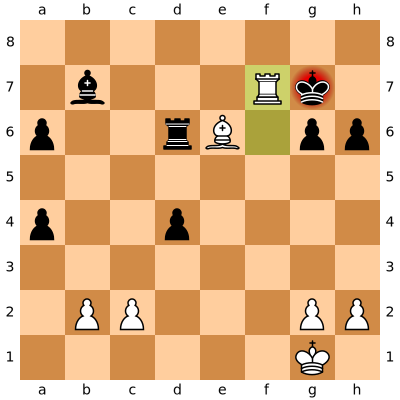

In [38]:
board = sampleb.board()
for m in sampleb.mainline_moves():
    print('{:>10} {:>6}'.format( board.variation_san([m]),
                                 str(board.turn)))
    board.push(m)
board

## Tratamentos

`symbol2value` recebe a representação de string das peças - brancas em _uppercase_ - e converte para inteiro. `list2piece` recebe a representação em inteiro e converte para a representação da peça segundo a biblioteca `chess`.

In [9]:
DICT1 = {'p':-60,'r':-50,'n':-40,'b':-30,'q':-20,'k':-10,'.':0,'K':10,'Q':20,'B':30,'N':40,'R':50,'P':60}
DICT2 = {-60:(chess.PAWN, chess.BLACK),
         -50:(chess.ROOK, chess.BLACK), 
         -40:(chess.KNIGHT, chess.BLACK), 
         -30:(chess.BISHOP, chess.BLACK), 
         -20:(chess.QUEEN, chess.BLACK), 
         -10:(chess.KING, chess.BLACK),
          0:'.',
         10:(chess.KING, chess.WHITE),
         20:(chess.QUEEN, chess.WHITE),
         30:(chess.BISHOP, chess.WHITE),
         40:(chess.KNIGHT, chess.WHITE),
         50:(chess.ROOK, chess.WHITE),
         60:(chess.PAWN, chess.WHITE)}

def symbol2value(list):
    for i, v in enumerate(list):
        if v in DICT1:
            list[i] = DICT1[v]
    return list


def list2piece(list):
    for i, v in enumerate(list):
        if v in DICT2:
            list[i] = DICT2[v]
    return list


def ceil_to_tens(x):
    return int(ceil(x / 10.0)) * 10

Abaixo `game2list` recebe um jogo pgn - ou seja, uma variável da classe pgn, e não um arquivo pgn -, a variável de cor da biblioteca `chess` e retorna uma lista de estados imediatamente anteriores ao movimento feito pela peça da cor selecionada, seguindo a seguinte estrutura:

```
matrix = [ estado_0, estado_1, ... , estado_n ]
      -> estado_i = [int_0, int_1, ..., int_63, int_moved_piece, int_moved_from, int_moved_to]
```

onde $int_0 = \text{a1}$, $int_1 = \text{b1}$, $\dots$, $int_{63} = \text{h8}$, estão **associadas** às casas do tabuleiro, todas **representadas** como inteiros de acordo com o mapeamento da `symbol2value`. 

Por exemplo no jogo do [exemplo acima](#Carregando-PGN), estudando o jogo das negras: o "`estado_1`", correspondente ao segundo estado do tabuleiro, teria "`estado_1[50] = -10`", representando o rei das peças negras na casa e8. 

As três últimas variáveis, `int_moved_piece`, `int_moved_from` e `int_moved_to` representam o movimento feito pela cor estudada. Nesse caso

```
1. e4  c5
```

"`estado_1[[64, 65, 66]] =  [-60, 50, 34]`", representando a resposta das peças negras ao primeiro estado do tabuleiro, um movimento de peão de c7 para c5.

Essa tripla fará papel de variável resposta do modelo de rede neural.

In [10]:
def game2list(g, color):
    matrix = list()
    board  = g.board()
    for m in g.mainline_moves():
        if board.turn == color:
            s = str(board)
            #state  = list( itertools.chain.from_iterable( [i.split() for i in s.split('\n')] ) )
            state  = [str(board.piece_at(i)) if board.piece_at(i) != None else '.' for i in range(64) ]
            target = [ str(board.piece_at(m.from_square)), m.from_square, m.to_square ]
            matrix.append( symbol2value(state + target) )
        board.push(m)
    return matrix

## Dataframe

Convertendo apenas respostas das peças negras para dataframe:

In [11]:
blackmoves = list()

for i in black:
    blackmoves += game2list(i, chess.BLACK)

In [12]:
blackmoves = pd.Series(blackmoves)
df =  pd.DataFrame.from_items(zip(blackmoves.index, blackmoves.values)).T
df.columns = [str(i) for i in range(67)]

In [13]:
df.shape

(34192, 67)

Definindo conjuntos de treino e teste:

In [14]:
X_train = df.drop(['64','65', '66'], axis=1)
y_train = df[['64','65', '66']]
X_test  = df.drop(['64','65', '66'], axis=1)

## Modelo

In [94]:
def net(train):
    seed(23)
    set_random_seed(23)
    
    model = Sequential()
    
    model.add(Dense(64, 
                    input_dim  = train.shape[1], 
                    activation = 'linear'))    
    #model.add(Dropout(0.05))
    model.add(Dense(64, activation = 'linear'))
    model.add(Dense(64, activation = 'linear'))
    #model.add(Dense(64, activation = keras.layers.ELU(alpha=1.13)))
    model.add(Dense(64, activation = 'linear'))
    model.add(Dense(32, activation = 'linear'))
    model.add(Dense(3))
    
    model.compile(loss = 'mean_squared_error', 
                  optimizer='Adadelta', 
                  metrics=['mse', 'accuracy'])
    
    return model

## Treino e Teste

In [95]:
model = net(X_train)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_69 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_70 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_71 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_72 (Dense)             (None, 3)                 99        
Total params: 18,819
Trainable params: 18,819
Non-trainable params: 0
_________________________________________________________________
None


In [96]:
training = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.3, verbose=2)

Train on 23934 samples, validate on 10258 samples
Epoch 1/25
 - 3s - loss: 343.8632 - mean_squared_error: 343.8632 - acc: 0.7236 - val_loss: 314.4959 - val_mean_squared_error: 314.4959 - val_acc: 0.7718
Epoch 2/25
 - 2s - loss: 272.7794 - mean_squared_error: 272.7794 - acc: 0.7635 - val_loss: 245.2118 - val_mean_squared_error: 245.2118 - val_acc: 0.7668
Epoch 3/25
 - 1s - loss: 223.0354 - mean_squared_error: 223.0354 - acc: 0.7694 - val_loss: 213.4882 - val_mean_squared_error: 213.4882 - val_acc: 0.7746
Epoch 4/25
 - 1s - loss: 208.2262 - mean_squared_error: 208.2262 - acc: 0.7717 - val_loss: 210.1784 - val_mean_squared_error: 210.1784 - val_acc: 0.7760
Epoch 5/25
 - 2s - loss: 204.5810 - mean_squared_error: 204.5810 - acc: 0.7714 - val_loss: 210.0454 - val_mean_squared_error: 210.0454 - val_acc: 0.7755
Epoch 6/25
 - 1s - loss: 202.3604 - mean_squared_error: 202.3604 - acc: 0.7720 - val_loss: 207.7201 - val_mean_squared_error: 207.7201 - val_acc: 0.7760
Epoch 7/25
 - 1s - loss: 201.366


val_acc: 77.53%


Text(0.5, 0, 'epoch')

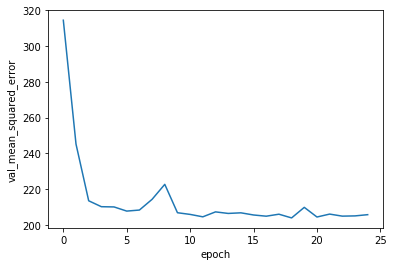

In [97]:
val_acc = np.mean(training.history['val_acc'])
print("\n%s: %.2f%%" % ('val_acc', val_acc*100))

fig = plt.figure()
fig.patch.set_facecolor('white')
#plt.plot(training.history['acc'])
#plt.plot(training.history['val_acc'])
plt.plot(training.history['val_mean_squared_error'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
plt.ylabel('val_mean_squared_error')
plt.xlabel('epoch');
#plt.legend(['train', 'validation'], loc='lower right')

In [43]:
def drawPredTrain(t, a):
    tstate = list2piece( t.values.tolist()[0] )
    pred  = model.predict(t).round().tolist()[0]
    pred = [ceil_to_tens(pred[0]), int(pred[1]), int(pred[2])]
    arrow = chess.svg.Arrow(tail = pred[1], 
                            head = pred[2])
    arrowans = chess.svg.Arrow(tail = a['65'].values[0], 
                            head = a['66'].values[0],
                              color='#f00')
    tboard = chess.Board()
    tboard.clear_board()
    for i,v in enumerate(tstate):
        if v != '.':
            tboard.set_piece_at(i, chess.Piece(v[0], v[1]))
            
    display( chess.svg.board(board = tboard, arrows=[arrow, arrowans], size=400) )
    
    return pred
    
    

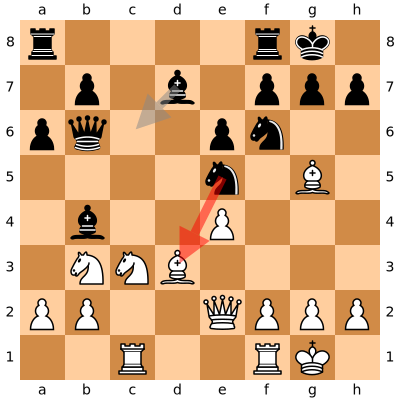

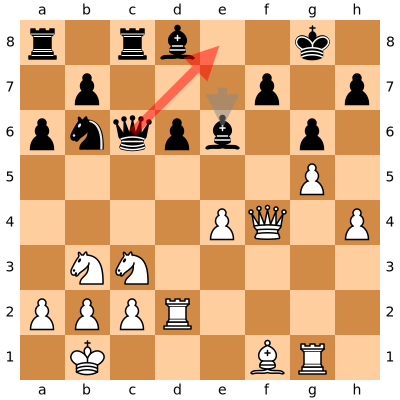

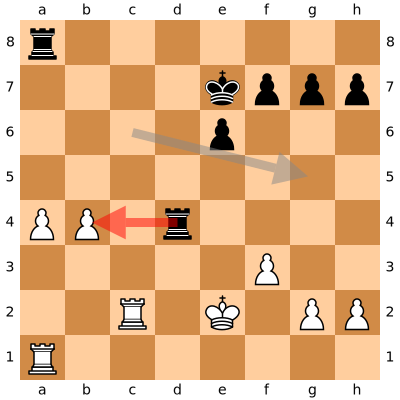

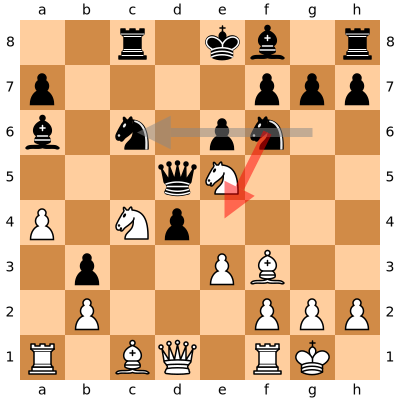

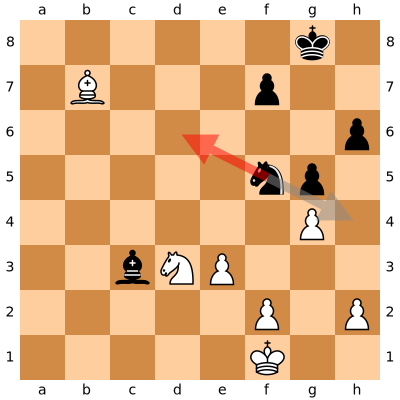

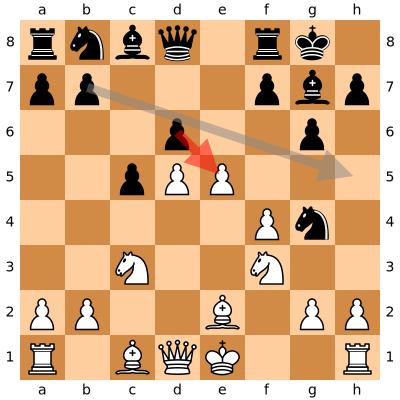

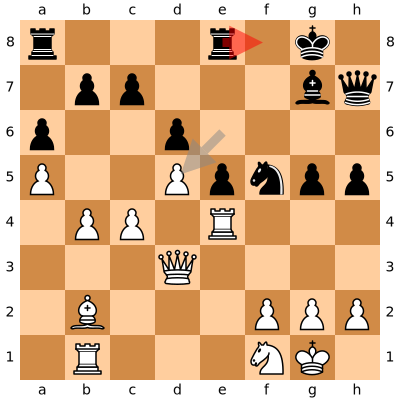

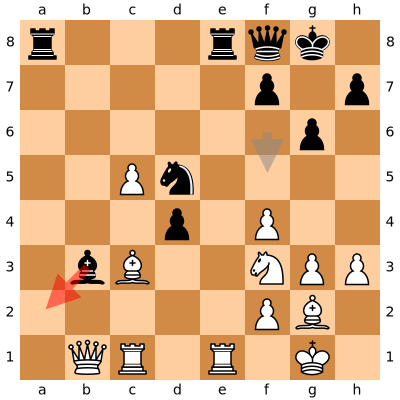

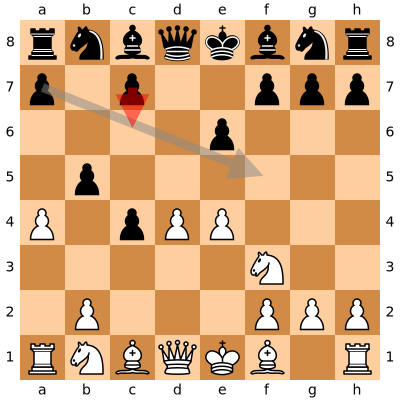

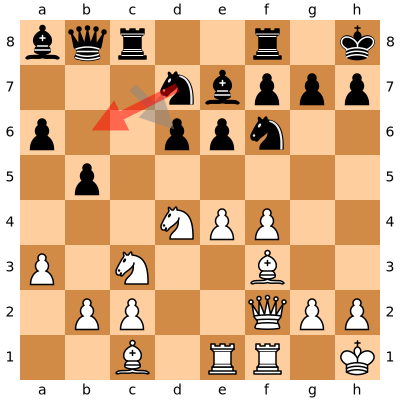

In [44]:
for i in range(10):
    teste = X_train.sample(1)
    testeid = teste.index
    testeans = y_train.iloc[testeid]

    p = drawPredTrain(teste, testeans)

# Referências

- [Download PGN Files](http://www.pgnmentor.com/files.html#players)

- - -

# Dataset building

In [59]:
import itertools
import re
import pickle
import os

import pandas as pd
import numpy as np
import chess
import chess.pgn
import chess.svg

from IPython.display import display

In [3]:
# https://en.wikipedia.org/wiki/List_of_World_Chess_Championships
# https://python-chess.readthedocs.io/en/latest/pgn.html
# https://regex101.com/
# https://regexr.com/

In [4]:
CHAMP = {}
champ = """ 1948, 1951, 1954 (Botvinnik)
            1957 (Smyslov)
            1958 (Botvinnik)
            1960 (Tal)
            1961 (Botvinnik)
            1963, 1966 (Petrosian)
            1969 (Spassky)
            1972 (Fischer)
            1975, 1978, 1981, 1984 (Karpov)
            1985, 1986, 1987, 1990 (Kasparov)
            1993, 1995 (Kasparov) 
            2000, 2004 (Kramnik)
            1993, 1996, 1998 (Karpov)
            1999 (Khalifman)
            2000 (Anand)
            2002 (Ponomariov)
            2004 (Kasimdzhanov)
            2005 (Topalov)
            2006 (Kramnik)
            2007, 2008, 2010, 2012 (Anand)
            2013, 2014, 2016, 2018 (Carlsen)""".split('\n')

for c in champ:
    alias = re.search(r'\((.+?)\)', c).group(1)
    reign = re.search(r'(.+)(\()', c).group(1).replace(' ', '').split(',')
    if alias not in CHAMP:
        CHAMP[alias] = set(reign)
    else:
        CHAMP[alias] = CHAMP[alias].union(set(reign))

In [108]:
DICT1 = {'p':-60, 'r':-50, 'n':-40, 'b':-30, 'q':-20, 'k':-10,
         '.':0,
         'K':10, 'Q':20, 'B':30, 'N':40, 'R':50, 'P':60}


DICT2 = {-60:(chess.PAWN, chess.BLACK),
         -50:(chess.ROOK, chess.BLACK), 
         -40:(chess.KNIGHT, chess.BLACK), 
         -30:(chess.BISHOP, chess.BLACK), 
         -20:(chess.QUEEN, chess.BLACK), 
         -10:(chess.KING, chess.BLACK),
          0:'.',
         10:(chess.KING, chess.WHITE),
         20:(chess.QUEEN, chess.WHITE),
         30:(chess.BISHOP, chess.WHITE),
         40:(chess.KNIGHT, chess.WHITE),
         50:(chess.ROOK, chess.WHITE),
         60:(chess.PAWN, chess.WHITE)}


def symbol2value(list):
    for i, v in enumerate(list):
        if v in DICT1:
            list[i] = DICT1[v]
    return list


def value2piece(list):
    for i, v in enumerate(list):
        if v in DICT2:
            list[i] = DICT2[v]
    return list


def game2list(g, tag='_tag', path='_path'):
    matrix = list()
    board  = g.board()
    meta   = dict(g.headers)
    print(meta)
    
    w_id = '{}'.format( meta['White'].split(',')[0].lower().replace(' ', '_') )
    b_id = '{}'.format( meta['Black'].split(',')[0].lower().replace(' ', '_') )
    
    players = { 'W' : w_id, 'B': b_id }
    
    
    turn_color = lambda s: 'W' if s == True else 'B'
    turn_count = 0
    game_path  = '{}/{}'.format(path, tag)
    
    #if not os.path.exists(game_path):
    #    os.makedirs(game_path)
    
    for m in g.mainline_moves():
            #with open('{}/chess_{}.svg'.format( game_path, str(turn_count).zfill(3) ), 'w') as img:
            #    img.write(chess.svg.board(board=board))
            
            
            #s      = str(board)
            state  = [str(board.piece_at(i)) if board.piece_at(i) != None else '.' for i in range(64) ]
            target = [ str(board.piece_at(m.from_square)), m.from_square, m.to_square ]
            #matrix.append( symbol2value(state + target) )
            _num_state   = symbol2value(state)
            _num_target  = symbol2value(target)
            _num_move    = {'moved_piece': _num_target[0],
                            'moved_from' : _num_target[1],
                            'moved_to'   : _num_target[2]}
            
            matrix.append( { 'player'          : players[turn_color(board.turn)],
                             'full_move_count' : board.fullmove_number,
                             'turn_count'      : str(turn_count).zfill(3),
                             'turn_color'      : turn_color(board.turn),
                             'state'           : _num_state,
                             'is_checkmate'    : board.is_checkmate(), 
                             'is_stalemate'    : board.is_stalemate(),
                             'is_castling'     : board.is_castling(m), 
                             'has_castling'    : board.has_castling_rights(board.turn),
                             'move'            : _num_move
                             } )
            
            board.push(m)
            turn_count += 1
            
                  
    return matrix

In [109]:
for c in sorted(CHAMP.items(), key = lambda x: sorted(x[1])[-1], reverse=True):
    alias = c[0]
    reign = c[1]
    
    NAMETAG = alias.lower() 
    
    #pgn   = open("data/{}.pgn".format(alias))
    #games = list()
    data  = dict()
    
    # collecting games
    
    #g = chess.pgn.read_game(pgn)
    #while g:
    #    games.append( g )
    #    g = chess.pgn.read_game(pgn)
    
    #pickle.dump(games, open("dic_games.p", "wb"))
    games = pickle.load(open("dic_games.p", 'rb'))
    
    # extracting information
    
    for i,g in enumerate(games[:45]):
        meta = dict(g.headers)
        
        id   = '{}{}'.format( NAMETAG, "{0:#0{1}x}".format(i,5) )
        
        if NAMETAG in meta['White'].lower():
            _id   = '{}{}'.format( meta['Black'].split(',')[0].lower().replace(' ', '_'), "{0:#0{1}x}".format(i,5) )
        elif NAMETAG in meta['Black'].lower():
            _id   = '{}{}'.format( meta['White'].split(',')[0].lower().replace(' ', '_'), "{0:#0{1}x}".format(i,5) )
        else:
            print('INCONSISTENCY FOUND!')
            break
        
        #
        
        print(id, _id)
       
        data[id] = game2list(g, id, 'tmp_game_img')
        
        break
    
    break

carlsen0x000 edvardsen0x000
{'WhiteElo': '2055', 'White': 'Edvardsen,R', 'Black': 'Carlsen,Magnus', 'Date': '2001.01.05', 'Result': '1/2-1/2', 'BlackElo': '', 'Event': 'Troll Masters', 'Site': 'Gausdal NOR', 'Round': '1', 'ECO': 'D12'}


In [145]:
df     = pd.DataFrame(data['carlsen0x000'])
_move  = df[['turn_count', 'move']].copy()

df = pd.concat([ df, pd.DataFrame(list(_move['move'])) ], axis=1 )
df.loc[:, 'id'] = 'carlsen0x000'
df = df[['id',
         'player', 
         'full_move_count', 
         'turn_count', 
         'turn_color',
         'has_castling', 
         'is_castling', 
         'is_checkmate', 
         'is_stalemate', 
         'state', 
         'moved_piece', 
         'moved_from', 
         'moved_to']]

In [146]:
df

,id,player,full_move_count,turn_count,turn_color,has_castling,is_castling,is_checkmate,is_stalemate,state,moved_piece,moved_from,moved_to
0,carlsen0x000,edvardsen,1,000,W,True,False,False,False,"[50, 40, 30, 20, 10, 30, 40, 50, 60, 60, 60, 6...",60,11,27
1,carlsen0x000,carlsen,1,001,B,True,False,False,False,"[50, 40, 30, 20, 10, 30, 40, 50, 60, 60, 60, 0...",-40,62,45
2,carlsen0x000,edvardsen,2,002,W,True,False,False,False,"[50, 40, 30, 20, 10, 30, 40, 50, 60, 60, 60, 0...",40,6,21
3,carlsen0x000,carlsen,2,003,B,True,False,False,False,"[50, 40, 30, 20, 10, 30, 0, 50, 60, 60, 60, 0,...",-60,51,35
4,carlsen0x000,edvardsen,3,004,W,True,False,False,False,"[50, 40, 30, 20, 10, 30, 0, 50, 60, 60, 60, 0,...",60,12,20
5,carlsen0x000,carlsen,3,005,B,True,False,False,False,"[50, 40, 30, 20, 10, 30, 0, 50, 60, 60, 60, 0,...",-30,58,37
6,carlsen0x000,edvardsen,4,006,W,True,False,False,False,"[50, 40, 30, 20, 10, 30, 0, 50, 60, 60, 60, 0,...",60,10,26
7,carlsen0x000,carlsen,4,007,B,True,False,False,False,"[50, 40, 30, 20, 10, 30, 0, 50, 60, 60, 0, 0, ...",-60,50,42
8,carlsen0x000,edvardsen,5,008,W,True,False,False,False,"[50, 40, 30, 20, 10, 30, 0, 50, 60, 60, 0, 0, ...",40,1,18
9,carlsen0x000,carlsen,5,009,B,True,False,False,False,"[50, 0, 30, 20, 10, 30, 0, 50, 60, 60, 0, 0, 0...",-60,52,44
